# Ice-bed temperatures for GHSZ calculations

#### Importing the required modules

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.tri as tri
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import time
import math
import random
import time
import dask
import dask.bag as db
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
from tqdm import tqdm
import h5py
import matplotlib.font_manager
from netCDF4 import Dataset 
import netCDF4 as nc
import xarray as xr
import gcsfs
import fsspec
import cartopy.crs as ccrs
import cmocean
import multiprocessing as mp
import re
import scipy.stats as stats

#### Setting up plotting parameters

In [2]:
# mpl.rcParams['figure.figsize'] = 5.0, 3.0 
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 200
plt.rcParams.update({
    'font.sans-serif': 'Arial', # need to run conda install -c conda-forge -y mscorefonts for Arial
    'font.family': 'Arial',
    'font.size': 11,
    'figure.titlesize': 12,
    'figure.titleweight': 'bold',
    'lines.linewidth' : 0.5,
    'lines.markersize' : 2,
    'xtick.labelsize' : 10,
    'ytick.labelsize' : 10,
    'grid.linewidth': 0.1,
    'axes.titlesize': 11,
    'axes.titleweight' : 'bold',
    'axes.labelsize': 11,
    'axes.labelweight': 'bold',
    'axes.linewidth': 0.5,
    'pdf.fonttype': 42
})

####  Loading the required parameters for temperature calculation

In [3]:
c_i = 2.1e3 # Heat capacity of ice
c_r = 2e3 # Heat capacity of basal rock
k_i = 2.3 # Thermal conductivity of ice
k_r = 2.0 # Thermal conductivity of basal rock
rho_i = 918.9 # Density of ice
rho_r = 1900 # Density of basal rock
alpha_i = k_i / rho_i / c_i # Alpha for ice
alpha_r = k_r / rho_r / c_r # Alpha for basal rock
n = 3 # Glen's flow law exponent
g = 9.81 # Gravitational acceleration
A = 2e-16 # Rheological constant determining soft ice as a function of temperature
atm = 101.32 # Atmospheric pressure in kPa

yr_to_s = 365.25*24*60*60 # Seconds in a year
dt_years = 1  # Temporal resolution / time step in years
dt = (dt_years*yr_to_s) #  Temporal resolution / calculation of time step in seconds

## 1. Obtaining and visualising input data

### 1.1 Plotting the data

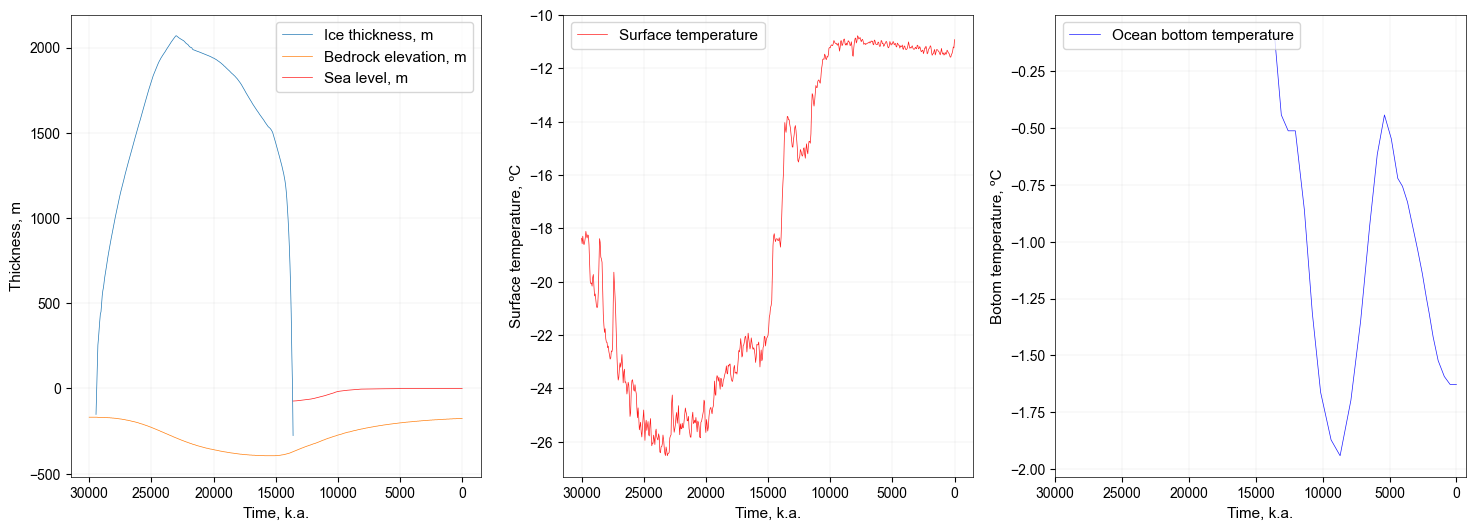

In [4]:
sealevel = np.genfromtxt('SL_Lambeck2014PNAS.csv', delimiter=',')

t_forcing = 30000
t_ungrounding = 13600

timesealevel = 1000*sealevel[0::2][:170]
nominalsl = np.flip(sealevel[1::2][:170])
timesealevel[0]=0
timesealevel[-1]= t_ungrounding
timesealevel = timesealevel + t_forcing - t_ungrounding

# data = np.genfromtxt('FJL_EIS_output_from_Patton.csv', delimiter=',', skip_header=11)

data = np.genfromtxt('FJL_EIS_output_from_Patton_100ka.csv', delimiter=',', skip_header=11)

bottomwater = np.genfromtxt('Svalbard bottom temp Serov PNAS 2016 digitised.csv', delimiter=',')
bottomwater[15,0] = t_ungrounding
bottomwater[-1,0] = 0
bottomwater[:,0] = bottomwater[:,0].astype(int)
bottomtemp = bottomwater[15:,1] - 5.5
bottomtime = np.flip(bottomwater[15:,0] + t_forcing - t_ungrounding)


t = np.flip(-data[-601:,0])
H = data[-601:,1]
T = data[-601:,2]
elev = data[-601:,3] + 70


fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
ax1, ax2, ax3  = axes

ax1.plot(t, H+elev, label='Ice thickness, m')
ax1.plot(t, elev, label='Bedrock elevation, m')
ax1.plot(timesealevel, nominalsl, 'r-', alpha=0.9, label='Sea level, m')
ax1.set_ylabel('Thickness, m')
ax1.set_xlabel('Time, k.a.')
ax1.xaxis.set_ticks(np.linspace(0,t_forcing,7).astype(int))
ax1.set_xticklabels(np.linspace(t_forcing,0,7).astype(int))
ax1.legend(loc='upper right')
ax1.grid()

ax2.plot(t, T, 'r-', alpha=0.9,  label='Surface temperature')
ax2.set_ylabel('Surface temperature, ºC')
ax2.set_xlabel('Time, k.a.')
ax2.xaxis.set_ticks(np.linspace(0,t_forcing,7).astype(int))
ax2.set_xticklabels(np.linspace(t_forcing,0,7).astype(int))
ax2.legend()
ax2.grid()

ax3.plot(bottomtime, bottomtemp, 'b-', alpha=0.9,  label='Ocean bottom temperature')
ax3.set_ylabel('Botom temperature, ºC')
ax3.set_xlabel('Time, k.a.')
ax3.xaxis.set_ticks(np.linspace(0,t_forcing,7).astype(int))
ax3.set_xticklabels(np.linspace(t_forcing,0,7).astype(int))
ax3.legend(loc='upper left')
ax3.grid()

### Interpolating sea level time series

In [5]:
time_sim_sealevel = np.linspace(t_forcing-t_ungrounding, t_forcing, num=int(t_ungrounding+1))
time_sim_elev = np.linspace(0, t_forcing, num=int(t_forcing+1))

fsealevel = interp1d(timesealevel, nominalsl)
felevation = interp1d(t, elev)
sealevelhistory = fsealevel(time_sim_sealevel)
elevationhistory = felevation(time_sim_elev)

# plt.plot(time_sim_sealevel,sealevelhistory)
# plt.plot(time_sim_elev,elevationhistory)

### 1.1 Plotting hydrate stability pressure-temperature curve from CSMHYD program

In [6]:
def pressure(density, thickness):
    return density*thickness*g/1000

(2517.7008413748617, 2108.446)

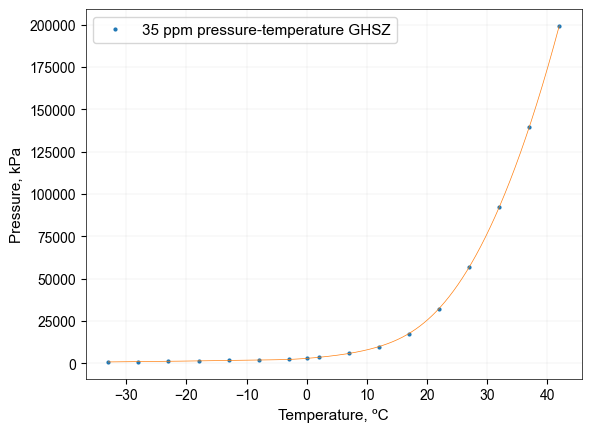

In [13]:
GHSZ = np.genfromtxt('Hydrate stability temperature - pressure 35 salinity.csv', delimiter=',')
GHSZt = GHSZ[:,0] - 273
GHSZp = GHSZ[:,1]


fGHSZ = interp1d(GHSZt, GHSZp, kind = 'cubic')


GHSZnew = np.linspace(min(GHSZt), max(GHSZt), num=1520, endpoint=True)

plt.plot(GHSZt, GHSZp, 'o', GHSZnew, fGHSZ(GHSZnew), '-')

plt.ylabel('Pressure, kPa')
plt.xlabel('Temperature, ºC')
plt.legend(['35 ppm pressure-temperature GHSZ'])
plt.grid()

np.max(fGHSZ(GHSZnew)[np.where(GHSZnew < -2)]), pressure(200,1023)+atm

## 2. Temperature profile forward model

### 2.2 Writing the forward model as a function

### 2.1 Loading the required parameters for temperature calculation

In [14]:
c_i = 2.1e3 # Heat capacity of ice
c_r = 2e3 # Heat capacity of basal rock
k_i = 2.3 # Thermal conductivity of ice
k_r = 2.0 # Thermal conductivity of basal rock
rho_i = 918.9 # Density of ice
rho_r = 1900 # Density of basal rock
alpha_i = k_i / rho_i / c_i # Alpha for ice
alpha_r = k_r / rho_r / c_r # Alpha for basal rock
n = 3 # Glen's flow law exponent
g = 9.81 # Gravitational acceleration
A = 2e-16 # Rheological constant determining soft ice as a function of temperature
atm = 101.32 # Atmospheric pressure in kPa

yr_to_s = 365.25*24*60*60 # Seconds in a year
dt_years = 1  # Temporal resolution / time step in years
dt = (dt_years*yr_to_s) #  Temporal resolution / calculation of time step in seconds

In [15]:
def Tmodel(Hi_sim, Hr, dz, t_steady_years_total, t_forcing_years, t_ungrounding, t_grounding, T_sim, a_sim, G, sealevel, elevation, Twater):

##################################################################################################################
    
    #### Defining spatial and temporal domains / resolution

    Hm = min(Hi_sim)  # Taking the minimum value of thickness history for domain calculation
    zi = np.linspace(0, Hm, int((Hm)/dz) + 1)  # Space calculation domain for ice
    dzr = dz  # Space resolution for bedrock
    zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for bedrock
    l = len(zr)  # Index for ice-bed interface to be used in the loop calculations 
    Lzi = len(zi) #  Number of elements in space domain for ice
    Lzr = len(zr) #  Number of elements in space domain for bedrock
    z = np.concatenate((zr[:-1],zi))  #  Merging space domains for ice and bedrock into one single unified space domain
    Lz = len(z) # Calculating the number of nodes in the unified space domain

    Tvar_H_matrix = np.zeros((Lz,int(t_forcing_years))) # Preparing temperature matrix for each step of temperature calculations
    zvar_H_matrix = np.zeros((Lz,int(t_forcing_years))) # Preparing depth matrix for each step of temperature calculations
    Pvar_H_matrix = np.zeros((Lz,int(t_forcing_years)))
    Pvar_H_stability_matrix = np.zeros((Lz,int(t_forcing_years)))
    
    #### Interpolating time-variable forcing vectors

    time_sim_T = np.linspace(1, int(t_forcing_years), num=len(T_sim))  # Creating an evenly spaced time vector for input surface temperature vector
    time_sim_Hi = np.linspace(1, int(t_forcing_years), num=len(Hi_sim)) # Creating an evenly spaced time vector for input thickness vector
    time_sim_a = np.linspace(1, int(t_forcing_years), num=len(a_sim)) # Creating an evenly spaced time vector for input accumulation vector
    time_sim_sealevel = np.linspace(t_forcing-t_ungrounding, t_forcing, num=len(sealevel))
    time_sim_elev = np.linspace(1, int(t_forcing_years), num=len(elevation))
    time_sim_bTw = np.linspace(t_forcing-t_ungrounding, t_forcing, num=len(Twater))
    
#     time_sim_sealevel = np.linspace(t_forcing-t_ungrounding, t_forcing, num=int(t_ungrounding+1))
#     time_sim_elev = np.linspace(0, t_forcing, num=int(t_forcing+1))   
#     time_sim_bTw = np.linspace(t_forcing-t_ungrounding, t_forcing, num=int(t_ungrounding+1))
    
    tmnew = np.linspace(1, t_forcing_years, num = int(t_forcing_years), endpoint=True) # Creating a uniform time vector with 1-year spacing
    tmnew_sea = np.linspace(t_forcing-t_ungrounding, t_forcing, num=int(t_ungrounding+1), endpoint=True) 
    
    f = interp1d(time_sim_T, T_sim) # Preparing interpolation function
    facc = interp1d(time_sim_a, a_sim) # Preparing interpolation function
    fthk = interp1d(time_sim_Hi, Hi_sim) # Preparing interpolation function
    fsealevel = interp1d(time_sim_sealevel, sealevel)
    felevation = interp1d(time_sim_elev, elevation)
    fbTw = interp1d(time_sim_bTw, Twater)
    
#     fsealevel = interp1d(timesealevel, nominalsl)
#     felevation = interp1d(t, elev)
#     fbTw = interp1d(bottomtime, Twater)
    

    thkhistory = fthk(tmnew) # Interpolating thickness vector over the new time vector
    temphistory = f(tmnew) # Interpolating surface temperature vector over the new time vector
    acchistory_yr = facc(tmnew) # Interpolating accumulation vector over the new time vector
    sealevelhistory = fsealevel(tmnew_sea)
    elevationhistory = felevation(tmnew)
    bottomwaterhistory = fbTw(tmnew_sea)
    
    
#     sealevelhistory = fsealevel(time_sim_sealevel)
#     elevationhistory = felevation(time_sim_elev)
#     bottomwaterhistory = fbTw(time_sim_bTw)
    
    acchistory = acchistory_yr / yr_to_s # Converting accumulation vector from m/yr to m/s
    
    a_steady = acchistory[0] # Taking the first value of the accumulation vector for steady state profile calculation
    Ts_surf_steady = temphistory[0] # Taking the first value of the temperature vector for steady state profile calculation
    Ts = -z*0 + Ts_surf_steady # Creating the initial temperature vector prior to the steady state profle calculation
    Twater_steady = bottomwaterhistory[0]
    #### Defining time before ungrounding/grounding events
    
    t_before_ungrounding = int(t_forcing_years) - int(t_ungrounding) - int(t_grounding) # Defining the time before the ungrounding
    t_before_grounding =  int(t_forcing_years) - int(t_grounding)  # Defining the time before the grounding

##################################################################################################################
    
# Start of loop iterations

### Ice shelf steady state T profile with constant ice thickness:
    
    for i in range(0, int(t_steady_years_total)):

        Hi = thkhistory[0]  # Taking the first value of thickness history for steady state calculation
        zi = np.linspace(0, Hi, Lzi)  #  Space calculation domain for ice of initial thickness
        dz = Hi/Lzi  # Space resolution for ice column
        z = np.concatenate((zr[:-1],zi))  #  Merging space domains for ice and bedrock into one single unified space domain
        
        
       # Grounded ice vertical velocity profile after Lliboutry (1979)
         
        # Ice shelf vertical velocity profile
    
        w = -np.linspace(a_steady,a_steady,Lzi) # Accumulation rate and basal melt/freeze rate are in balance

        # Advection-diffusion temperature calculation above ice-rock interface
        
        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(w[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = Ts_surf_steady # Temperature forcing is constant and equals the first value of the imported Monte-Carlo surface temperature vectors
        
        Ts[l-1] = Twater_steady #-1.89 - 7.53e-4*Hi
            
        # Diffusion temperature calculation below ice-rock interface

        Ts[1:l-1] = Ts[1:l-1] + dt*alpha_r*(Ts[2:l]-2*Ts[1:l-1]+Ts[0:l-2])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)
       
    
#     for i in range(0, int(t_steady_years_total/5)):
        
#         dws = a_steady  
#         wzt = (1 - (((n + 2) / (n + 1)) * (1 - zi / Hi)) + (1 / (n + 1)) * np.power((1 - zi / Hi), (n + 2)))
#         ws = -dws * wzt 

#         # Advection-diffusion temperature calculation above ice-rock interface
        
#         Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(ws[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
#         Ts[-1] = Ts_surf_steady # Temperature forcing is constant and equals the first value of the input surface temperature vector
        
#         # Diffusion temperature calculation below ice-rock interface
    
#         Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dzr**2
#         Ts[0] = Ts[1] + (G/k_r*dzr)
        
        
        
### Grounded ice T profile with time-variable forcings:

    for j in range(0, int(t_before_ungrounding)):
        
        
        #  Introducing time-variable ice thickness and recalculating ice column mesh grid at each step 
        
        Hi = thkhistory[j]
        zi = np.linspace(0, Hi, Lzi)
        dz = Hi/Lzi
        z = np.concatenate((zr[:-1],zi)) 
        
        #  Interpolating temperature profile at a previous time step on to the new(current) ice column grid
        
        zint = np.linspace(0, thkhistory[j-1], Lzi)
        s = InterpolatedUnivariateSpline(zint, Ts[l-1:], k=1) 
        
        Ts[l-1:] = s(zi)
        
    
        # Grounded ice vertical velocity profile after Lliboutry (1979)

        dws = acchistory[j] - ((thkhistory[j] - thkhistory[j - 1]) / dt); # When thickness is variable through time
        wzt = (1 - (((n + 2) / (n + 1)) * (1 - zi / Hi)) + (1 / (n + 1)) * np.power((1 - zi / Hi), (n + 2)))
        ws = -dws * wzt

        # Advection-diffusion temperature calculation above ice-rock interface
        
        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(ws[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = temphistory[j] # Temperature forcing equals value of the imported surface temperature vector at each point in time
        
        # Diffusion temperature calculation below ice-rock interface
    
        Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)


        # Recording the results into the temperature and depth matrixes
    
        Tvar_H_matrix[:,j] = Ts
        zvar_H_matrix[:,j] = z
        
        
        GHSZ = np.genfromtxt('Hydrate stability temperature - pressure 35 salinity.csv', delimiter=',')
        GHSZt = GHSZ[:,0] - 273
        GHSZp = GHSZ[:,1]

        fg = interp1d(GHSZt, GHSZp)
        xnewg = np.linspace(min(GHSZt), max(GHSZt), num=1520, endpoint=True)
        
        for k in range (0, Lzr):
            p = atm + pressure(rho_i, Hi) + pressure(rho_r, -zr[k])
            Pvar_H_matrix[k,j] = p
            if p < np.max(fg(xnewg)[np.where(xnewg < Ts[k])]):
                Pvar_H_stability_matrix[k,j] = 1
            

        
### Introduce ungrounding event:

    for jj in range(0, int(t_ungrounding)):
        
        
        #  Recalculating ice column space domain based on thickness at each step 
        
        Hi = thkhistory[jj+t_before_ungrounding]
        zi = np.linspace(0, Hi, Lzi)
        dz = Hi/Lzi
        z = np.concatenate((zr[:-1],zi))        
    
        #  Interpolating temperature profile at a previous time step on to the new(current) ice column grid

        zint = np.linspace(0, thkhistory[jj+t_before_ungrounding-1], Lzi) 
        s = InterpolatedUnivariateSpline(zint, Ts[l-1:], k=1)
        Ts[l-1:] = s(zi)
        
        
        # Ice shelf vertical velocity profile (linear function)
    
        w = -np.linspace(acchistory[jj+t_before_ungrounding],acchistory[jj+t_before_ungrounding],Lzi) # Accumulation rate and basal melt/freeze rate are in balance

        # Advection-diffusion temperature calculation above ice-rock interface
        
        Ts[l:-1] = bottomwaterhistory[jj] # Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(w[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = bottomwaterhistory[jj] # temphistory[jj+t_before_ungrounding] # Temperature forcing is constant and equals the first value of the imported Monte-Carlo surface temperature vectors
        
        Ts[l-1] = bottomwaterhistory[jj] #-1.89 - 7.53e-4*Hi
            
        # Diffusion temperature calculation below ice-rock interface

        Ts[1:l-1] = Ts[1:l-1] + dt*alpha_r*(Ts[2:l]-2*Ts[1:l-1]+Ts[0:l-2])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)
        
        
        # Recording the results into the temperature and depth matrixes
        
        Tvar_H_matrix[:,jj+t_before_ungrounding] = Ts
        zvar_H_matrix[:,jj+t_before_ungrounding] = z
        
        for k in range (0, Lzr):
            p = atm + pressure(1023, -elevationhistory[jj+t_before_ungrounding]+sealevelhistory[jj]) + pressure(rho_r, -zr[k])
            Pvar_H_matrix[k,jj+t_before_ungrounding] = p
            if  p < np.max(fg(xnewg)[np.where(xnewg < Ts[k])]):
                Pvar_H_stability_matrix[k,jj+t_before_ungrounding] = 1 

        
    # Recording all of the results into the temperature-depth profile tuple that contains all calculations at each step of the simulation
    
    return {'Tmeasured':Ts, 'z':z, 'Tvar_H_Tmatrix':Tvar_H_matrix, 'zvar_H_Tmatrix':zvar_H_matrix, 'Pvar_H_Tmatrix':Pvar_H_matrix, 'Pvar_H_stability_Tmatrix':Pvar_H_stability_matrix}

## 3. Running thermal simulations with input from Patton EIS model

### 3.1 Calculating temperature evolution with variable ocean bottom temperature

In [16]:
%%time

H1 = H
H1[np.isnan(H1)] = 500
H1[327:] = 500
H[:16] = 500

T30_varT = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 30e-3, nominalsl, elev, bottomtemp)
# T40_varT = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 40e-3, nominalsl, elev, bottomtemp)
# T50_varT = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 50e-3, nominalsl, elev, bottomtemp)
T60_varT = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 60e-3, nominalsl, elev, bottomtemp)
# T70_varT = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 70e-3, nominalsl, elev, bottomtemp)
# T80_varT = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 80e-3, nominalsl, elev, bottomtemp)
T90_varT = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 90e-3, nominalsl, elev, bottomtemp)

# T110_varT = Tmodel(H1+200, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 110e-3, nominalsl, elev, bottomtemp)


# T80_m2 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 80e-3, nominalsl, elev, [-2, -2])
# T50_m2 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 50e-3, nominalsl, elev, [-2, -2])

# T30_0m1 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 30e-3, nominalsl, elev, [0, -1.2])
# T60_0m1 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 60e-3, nominalsl, elev, [0, -1.2])
# T90_0m1 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 90e-3, nominalsl, elev, [0,-1.2])


# T30_2m0 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 30e-3, nominalsl, elev, [-2, 0,-1.2])
# T60_2m0 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 60e-3, nominalsl, elev, [-2, 0,-1.2])
# T90_2m0 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 90e-3, nominalsl, elev, [-2, 0,-1.2])

# T80_m1 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 80e-3, nominalsl, elev, [-1.2, -1.2])
# T50_m1 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 50e-3, nominalsl, elev, [-1.2, -1.2])

# T66_varT = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 66e-3, nominalsl, elev, bottomtemp)

CPU times: user 6min 13s, sys: 4.84 s, total: 6min 18s
Wall time: 6min 18s


### 3.2 Calculating temperature evolution with constant ocean bottom temperature

In [17]:
%%time

t_w = -1.25

T30_m1 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 30e-3, nominalsl, elev, [t_w, t_w, t_w])
# T40_m1 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 40e-3, nominalsl, elev, [t_w, t_w, t_w])
# T50_m1 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 50e-3, nominalsl, elev, [t_w, t_w, t_w])
T60_m1 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 60e-3, nominalsl, elev, [t_w, t_w, t_w])
# T70_m1 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 70e-3, nominalsl, elev, [t_w, t_w, t_w])
# T80_m1 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 80e-3, nominalsl, elev, [t_w, t_w, t_w])
T90_m1 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 90e-3, nominalsl, elev, [t_w, t_w, t_w])

t_w = -0

T30_m0 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 30e-3, nominalsl, elev, [t_w, t_w, t_w])
# T50_m0 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 40e-3, nominalsl, elev, [t_w, t_w, t_w])
# T50_m0 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 50e-3, nominalsl, elev, [t_w, t_w, t_w])
T60_m0 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 60e-3, nominalsl, elev, [t_w, t_w, t_w])
# T70_m0 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 70e-3, nominalsl, elev, [t_w, t_w, t_w])
# T80_m0 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 80e-3, nominalsl, elev, [t_w, t_w, t_w])
T90_m0 = Tmodel(H1, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T, [0.1, 0.1], 90e-3, nominalsl, elev, [t_w, t_w, t_w])


# T100_varT = Tmodel(H1+300, 1500, 10, 4e5, t_forcing, t_ungrounding, 0, T+3, [0.1, 0.1], 110e-3, nominalsl, elev, bottomtemp)
# T60_exp = Tmodel([2800, 2800], 1500, 10, 4e5, t_forcing, t_ungrounding, 0, [-50, -50], [0.1, 0.1], 40e-3, nominalsl, elev, [-0.5, 0, -0.5])

CPU times: user 12min 26s, sys: 7.23 s, total: 12min 33s
Wall time: 12min 32s


In [29]:
Tmin = T30_m1
Tmed = T60_m1
Tmax = T90_m1

T = Tmed

Tvar_H_matrix = T['Tvar_H_Tmatrix']
Tvar_H_matrix[151:,t_forcing-t_ungrounding:] = 10000
zvar_H_matrix = T['zvar_H_Tmatrix']
Pvar_H_matrix = T['Pvar_H_Tmatrix']
Pvar_H_stability_matrix_max = Tmax['Pvar_H_stability_Tmatrix']
Pvar_H_stability_matrix_med = Tmed['Pvar_H_stability_Tmatrix']
Pvar_H_stability_matrix_min = Tmin['Pvar_H_stability_Tmatrix']

# Pvar_H_matrix[:,:800] = Pvar_H_matrix[:,:800] - pressure(rho_i,500) + pressure(1023,170)
Pvar_H_matrix[150:,:] = 0
Pvar_H_stability_matrix_max[150:,:] = 1
Pvar_H_stability_matrix_med[150:,:] = 1
Pvar_H_stability_matrix_min[150:,:] = 1

### 3.3 Visualising modelling results

In [30]:
%%time

delta = 100

zvar_H_vector = np.asarray(zvar_H_matrix).reshape(-1)
Tvar_H_vector = np.asarray(Tvar_H_matrix).reshape(-1)
Pvar_H_vector = np.asarray(Pvar_H_matrix).reshape(-1)
Pvar_H_stability_max_vector = np.asarray(Pvar_H_stability_matrix_max).reshape(-1)
Pvar_H_stability_med_vector = np.asarray(Pvar_H_stability_matrix_med).reshape(-1)
Pvar_H_stability_min_vector = np.asarray(Pvar_H_stability_matrix_min).reshape(-1)

zvar_H_vectorrsmpld = np.asarray(zvar_H_matrix[:,::delta]).reshape(-1)
Tvar_H_vectorrsmpld = np.asarray(Tvar_H_matrix[:,::delta]).reshape(-1)
Pvar_H_vectorrsmpld = np.asarray(Pvar_H_matrix[:,::delta]).reshape(-1)
Pvar_H_stability_max_vectorrsmpld = np.asarray(Pvar_H_stability_matrix_max[:,::delta]).reshape(-1)
Pvar_H_stability_med_vectorrsmpld = np.asarray(Pvar_H_stability_matrix_med[:,::delta]).reshape(-1)
Pvar_H_stability_min_vectorrsmpld = np.asarray(Pvar_H_stability_matrix_min[:,::delta]).reshape(-1)


npts = Tvar_H_vectorrsmpld.shape[0]
ngridx = Tvar_H_matrix[:,::delta].shape[1]
ngridy = Tvar_H_matrix[:,::delta].shape[0]
x = np.tile(np.linspace(0,ngridx,ngridx), ngridy)
y = zvar_H_vectorrsmpld
z = Tvar_H_vectorrsmpld
zp = Pvar_H_vectorrsmpld
zpsmax = Pvar_H_stability_max_vectorrsmpld
zpsmed = Pvar_H_stability_med_vectorrsmpld
zpsmin = Pvar_H_stability_min_vectorrsmpld

xi = np.linspace(0,ngridx,int(ngridx/(delta)))
yi = np.linspace(-2000,2500,ngridy)

# Linearly interpolate the data (x, y) on a grid defined by (xi, yi)

triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

f = interp1d(t, elev)
elevnew = np.linspace(min(t), max(t), num=int(t_forcing/delta), endpoint=True)
elevy = np.tile(f(elevnew),ngridy)

CPU times: user 1.15 s, sys: 29.9 ms, total: 1.18 s
Wall time: 1.18 s


Text(0.5, 0, 'Time before present, years')

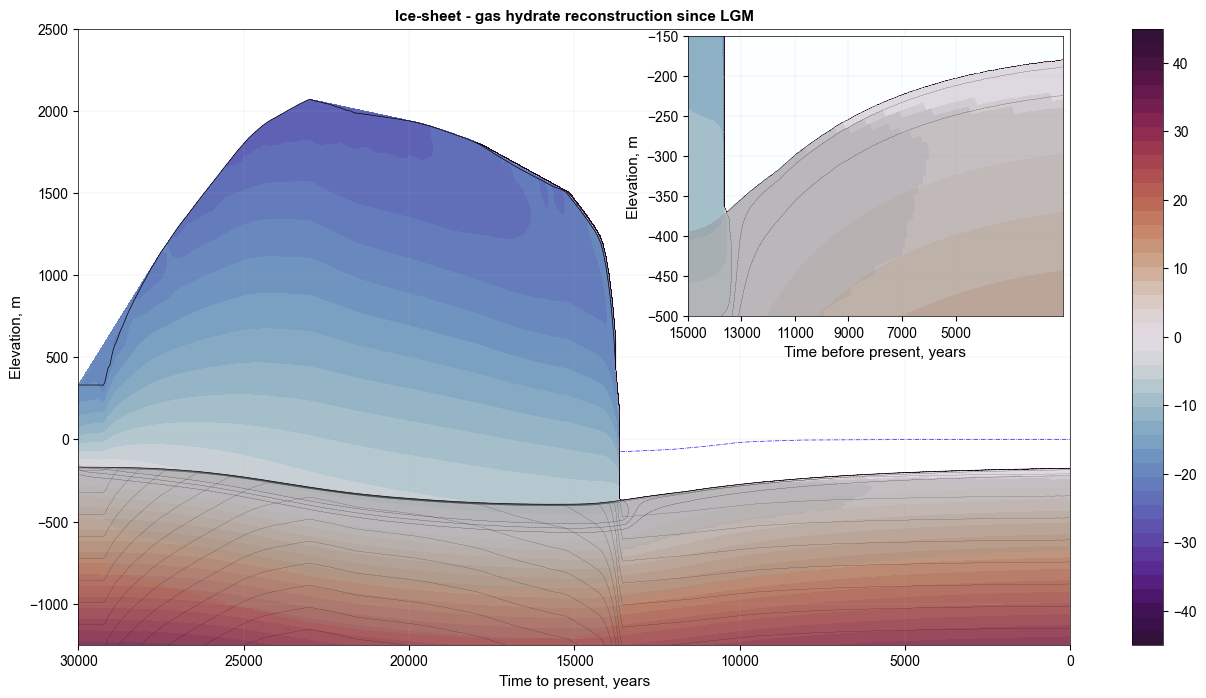

In [31]:
fig, (ax1) = plt.subplots(figsize=(16, 8), nrows=1)

ax1.tricontour(x*delta, y+elevy, zp, levels=np.linspace(0,50000, num=21), linewidths=0.1, colors='k')
ax1.tricontour(x*delta, y+elevy, z, levels=np.linspace(-2,0, num=3), linewidths=0.2, colors='k', linestyles = 'dashed')
cntr1 = ax1.tricontourf(x*delta, y+elevy, z, levels=np.linspace(-45,45, num=45), cmap="twilight_shifted")
ax1.tricontourf(x*delta, y+elevy, zpsmin, levels=np.linspace(0,1, num=2), alpha = 0.2, cmap = "Greys")
ax1.tricontourf(x*delta, y+elevy, zpsmed, levels=np.linspace(0,1, num=2), alpha = 0.2, cmap = "Greys")
ax1.tricontourf(x*delta, y+elevy, zpsmax, levels=np.linspace(0,1, num=2), alpha = 0.2, cmap = "Greys")
# ax1.tricontour(x*delta, y+elevy, zpsmax, linewidths=0.1, colors='r',linestyles = 'dashed')
# ax1.tricontour(x*delta, y+elevy, zpsmed, linewidths=0.1, colors='w',linestyles = 'dashed')
# ax1.tricontour(x*delta, y+elevy, zpsmin, linewidths=0.1, colors='b',linestyles = 'dashed')
# cntr2 = ax1.tricontourf(x*100, y+elevy, zps, levels=np.linspace(0,1, num=2), cmap="RdGy", alpha = 0.2)

# ax1.fill_between(time_sim_sealevel,sealevelhistory,elevationhistory[t_forcing-t_ungrounding:],color='azure',alpha=0.25,edgecolor='none', label=r'$1\sigma$ Spread')

fig.colorbar(cntr1, ax=ax1, ticks = np.linspace(-40,40,9))

ax1.set(xlim=(0, t_forcing), ylim=(-1250, 2500))
ax1.plot(t[:326], H[:326]+elev[:326], label='Ice thickness, m', color='k')
ax1.plot(time_sim_sealevel,sealevelhistory, 'b-.', alpha=0.9, label='Sea level, m')
ax1.plot(time_sim_elev,elevationhistory, color='k', linewidth=0.5, alpha=0.9, label='Seafloor elevation, m')

ax1.set_title('Ice-sheet - gas hydrate reconstruction since LGM')
ax1.grid()
ax1.set_ylabel('Elevation, m')
ax1.set_xlabel('Time to present, years')
ax1.xaxis.set_ticks(np.linspace(0,t_forcing,7).astype(int))
ax1.set_xticklabels(np.linspace(t_forcing,0,7).astype(int))

t_cut = 15000
axins = inset_axes(ax1, width=3.75, height=2.8, loc='upper right')
axins.tricontour(x*delta, y+elevy, z, levels=np.linspace(-2,0, num=3), linewidths=0.2, colors='k', linestyles = 'dashed')
cntr1 = axins.tricontourf(x*delta, y+elevy, z, levels=np.linspace(-35,35, num=35), cmap="twilight_shifted")
# axins.tricontour(x*delta, y+elevy, zpsmax, linewidths=0.1, colors='r',linestyles = 'dashed')
# axins.tricontour(x*delta, y+elevy, zpsmed, linewidths=0.1, colors='w',linestyles = 'dashed')
# axins.tricontour(x*delta, y+elevy, zpsmin, linewidths=0.1, colors='b',linestyles = 'dashed')
axins.tricontourf(x*delta, y+elevy, zpsmin, levels=np.linspace(0,1, num=2), alpha = 0.2, cmap = "Greys")
axins.tricontourf(x*delta, y+elevy, zpsmed, levels=np.linspace(0,1, num=2), alpha = 0.2, cmap = "Greys")
axins.tricontourf(x*delta, y+elevy, zpsmax, levels=np.linspace(0,1, num=2), alpha = 0.2, cmap = "Greys")
axins.set(xlim=(t_cut, t_forcing-1000), ylim=(-500, -150))
axins.plot(time_sim_sealevel,sealevelhistory, 'b-.', alpha=0.9, label='Sea level, m')
axins.fill_between(time_sim_sealevel,sealevelhistory,elevationhistory[t_forcing-t_ungrounding:],color='azure',alpha=0.25,edgecolor='none', label=r'$1\sigma$ Spread')
axins.grid()
axins.xaxis.set_ticks(np.linspace(t_cut,t_forcing-5000,6).astype(int))
axins.set_xticklabels(np.linspace(t_forcing-t_cut,5000,6).astype(int))
axins.set_ylabel('Elevation, m')
axins.set_xlabel('Time before present, years')

# axins1 = inset_axes(axins, width=1.5, height=0.8, loc='lower right')
# axins1.plot(t_cut-bottomtime, np.flip(bottomtemp))
# axins1.grid()

# axins = inset_axes(ax1, width=1.5, height=1.0, loc='upper right')
# axins.plot(GHSZnew, fGHSZ(GHSZnew), 'k-')
# axins.grid()
# axins.set_ylabel('Pressure, kPa')
# axins.set_xlabel('Temperature, ºC')

# axins1 = inset_axes(ax1, width=2.0, height=1.5, loc='center right')
# h = axins1.contourf(np.linspace(t_forcing-t_ungrounding, t_forcing, 2), -Water[4:], colour.T[4:], levels=np.linspace(-5,5, num=100), cmap = 'RdBu_r')
# axins1.plot(time_sim_sealevel, elevationhistory[t_forcing-t_ungrounding:]-sealevelhistory, 'k')
# axins1.fill_between(time_sim_sealevel,elevationhistory[t_forcing-t_ungrounding:]-sealevelhistory+25,elevationhistory[t_forcing-t_ungrounding:]-sealevelhistory-25,color='grey',alpha=0.25,edgecolor='k', label=r'$1\sigma$ Spread')
# axins1.set_xlabel('Time, years')
# axins1.set_ylabel('Water depth, m')
# axins1.grid()

# fig.savefig('Temperature simulations_.pdf')